In [ ]:
# Financial Fraud Detection with Balanced Precision/Recall

## 1. Setup and Installation
!pip install tensorflow scikit-learn imbalanced-learn > /dev/null



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (284807, 31)

Class distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


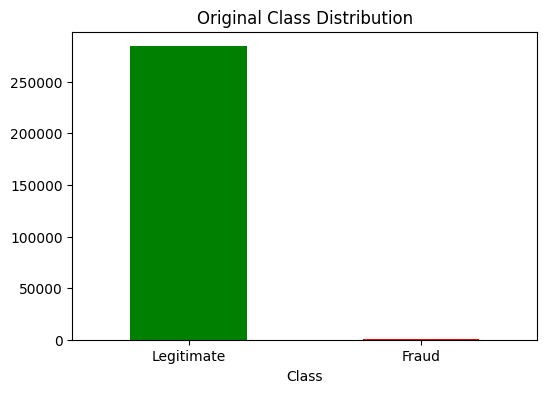

In [ ]:
# 2. Data Loading and Exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load data
data_path = '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/creditcard.csv'
df = pd.read_csv(data_path)

# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True))

# Visualize imbalance
plt.figure(figsize=(6,4))
df['Class'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Original Class Distribution')
plt.xticks([0,1], ['Legitimate', 'Fraud'], rotation=0)
plt.show()

In [ ]:
#  3. Data Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Normalize Amount and Time
scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Train-test split (before any resampling)
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# 4. Sequence Generation
def create_sequences(data, labels, seq_length=30, fraud_ratio=0.3):
    """
    Creates sequences with:
    - Minimum 30 timesteps for better patterns
    - Controlled fraud representation (30% by default)
    - Ensures fraud cases are properly isolated
    """
    fraud_indices = np.where(labels==1)[0]
    legit_indices = np.where(labels==0)[0]

    sequences, targets = [], []

    # 1. Add all available fraud sequences
    for i in fraud_indices:
        if i > seq_length and (i + 5) < len(data):  # Ensure isolation
            seq = data.iloc[i-seq_length:i]
            sequences.append(seq.values)
            targets.append(1)

    # 2. Calculate number of legitimate sequences needed
    n_fraud = len(targets)
    n_legit = int(n_fraud * (1-fraud_ratio)/fraud_ratio)

    # 3. Add legitimate sequences
    selected_indices = np.random.choice(legit_indices, min(n_legit, len(legit_indices)), replace=False)
    for i in selected_indices:
        if i > seq_length:
            seq = data.iloc[i-seq_length:i]
            sequences.append(seq.values)
            targets.append(0)

    return np.array(sequences), np.array(targets)

# Create optimized sequences
X_train_seq, y_train_seq = create_sequences(pd.DataFrame(X_train), y_train, fraud_ratio=0.3)
X_test_seq, y_test_seq = create_sequences(pd.DataFrame(X_test), y_test, fraud_ratio=0.3)

print(f"\nTraining sequences: {X_train_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print("Class balance in training sequences:")
print(pd.Series(y_train_seq).value_counts(normalize=True))


Training sequences: (1313, 30, 30)
Test sequences: (326, 30, 30)
Class balance in training sequences:
0    0.699924
1    0.300076
Name: proportion, dtype: float64


In [ ]:
# 5. LSTM Model Implementation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def build_optimized_model(input_shape):
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)

    # Self-attention mechanism using TensorFlow's built-in Attention
    query = Dense(64)(x)
    key = Dense(64)(x)
    value = Dense(64)(x)
    attention_output = Attention()([query, key, value])

    # Concatenate with LSTM output
    x = Concatenate()([x, attention_output])
    x = LSTM(64, return_sequences=False)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    # Enhanced focal loss
    def focal_loss(y_true, y_pred, alpha=0.8, gamma=2.0):
        bce = tf.keras.losses.BinaryCrossentropy(reduction='none')(y_true, y_pred)
        pt = tf.exp(-bce)
        loss = alpha * tf.pow(1-pt, gamma) * bce
        return tf.reduce_mean(loss)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0005),
        loss=focal_loss,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

model = build_optimized_model(X_train_seq.shape[1:])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 30, 30)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 256)   │    162,816 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 30, 64)    │     16,448 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 30, 64)    │     16,448 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30, 64)    │     16,448 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 64)    │          0 │ dense_6[0][0],    │
│ (Attention)         │                   │            │ dense_7[0][0],    │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 320)   │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 64)        │     98,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         33 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 312,833 (1.19 MB)

 Trainable params: 312,833 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 6. Model Training
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    baseline=0.8,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight={0:1, 1:30},
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - auc: 0.4850 - loss: 1.6398 - precision: 0.3854 - recall: 0.2842 - val_auc: 0.0000e+00 - val_loss: 0.1110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - auc: 0.6603 - loss: 1.5491 - precision: 0.7465 - recall: 0.0374 - val_auc: 0.0000e+00 - val_loss: 0.1118 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - auc: 0.6774 - loss: 1.4806 - precision: 0.6555 - recall: 0.1320 - val_auc: 0.0000e+00 - val_loss: 0.0938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - auc: 0.7641 - loss: 1.4741 - precision: 0.7024 - recall: 0.3525 - val_auc: 0.0000e+00 - val_loss: 0.1057 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - auc: 0.7965 - loss: 1.3923 - precision: 0.7751 - recall: 0.4539 - val_auc: 0.0000e+00 - val_loss

In [ ]:
# 7. Threshold Optimization
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities
y_probs = model.predict(X_test_seq).ravel()

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test_seq, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Optimal Threshold: 0.4510



Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

  Legitimate       0.82      0.14      0.24       228
       Fraud       0.32      0.93      0.47        98

    accuracy                           0.38       326
   macro avg       0.57      0.53      0.36       326
weighted avg       0.67      0.38      0.31       326



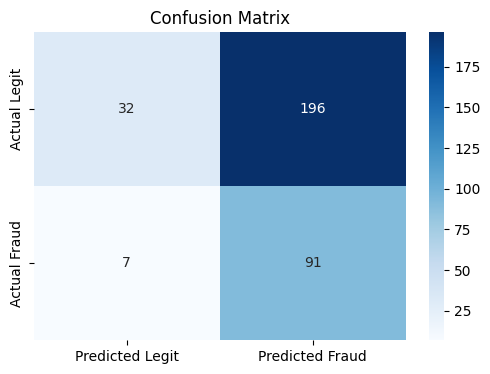

In [ ]:
# 8. Final Evaluation
# Evaluate with optimal threshold
y_pred = (y_probs > optimal_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report at Optimal Threshold:")
print(classification_report(y_test_seq, y_pred, target_names=['Legitimate', 'Fraud']))

# Confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Legit', 'Predicted Fraud'],
            yticklabels=['Actual Legit', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.show()



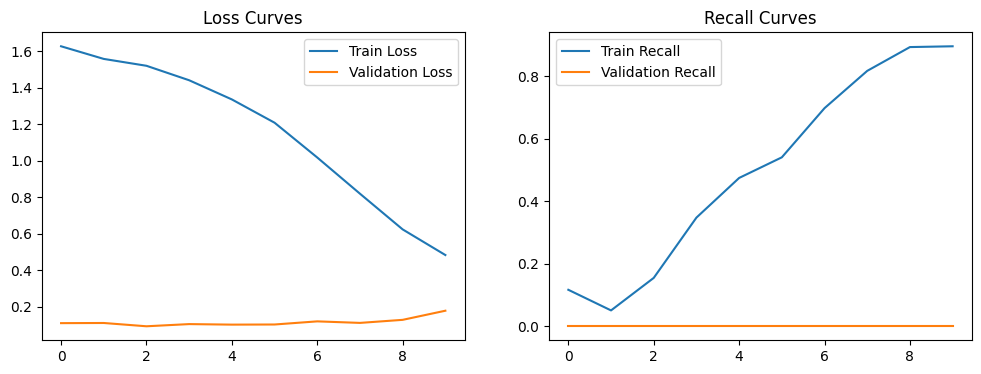

In [ ]:
# 9. Training History Visualization
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curves')
plt.legend()
plt.show()